# Use case 2 — Predict future buying behavior (customer-level classification)

In [0]:
!pip install openpyxl

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

✅ Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00       738

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



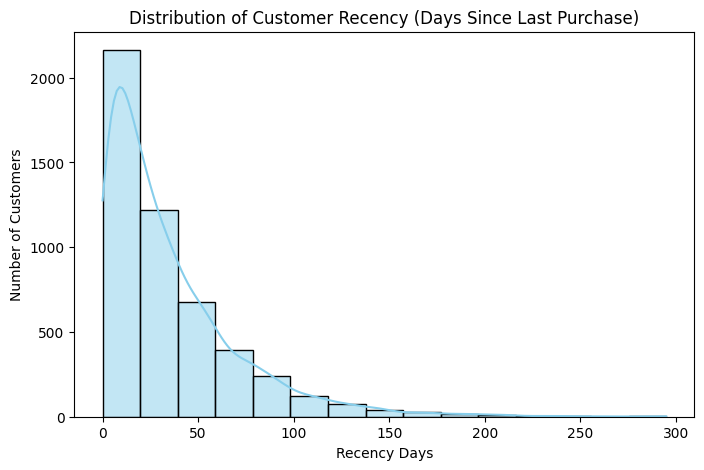

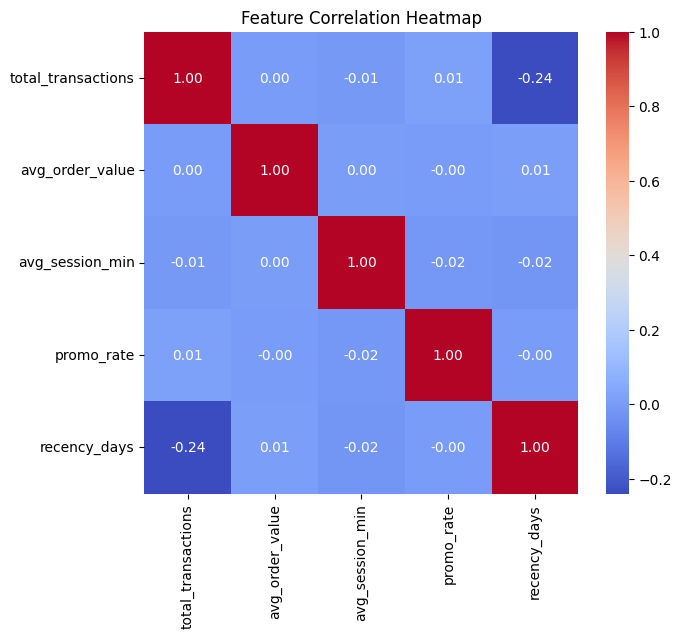

/home/spark-26717f64-6f6d-46a0-a498-78/.ipykernel/5808/command-4778817119467306-4025990628:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="coef", y="feature", data=coef_df, palette="viridis")


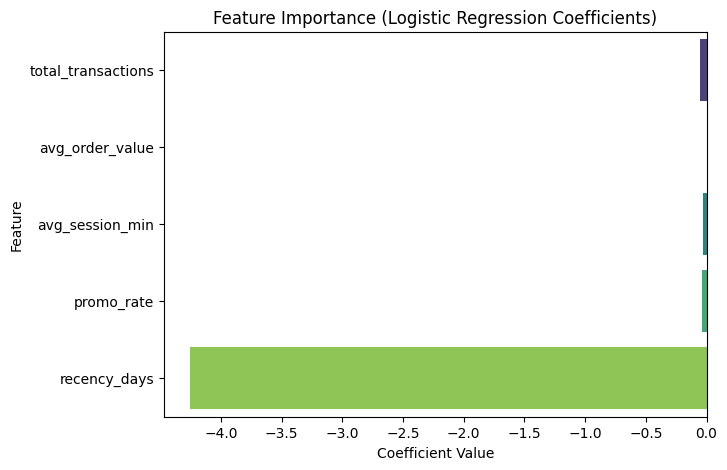

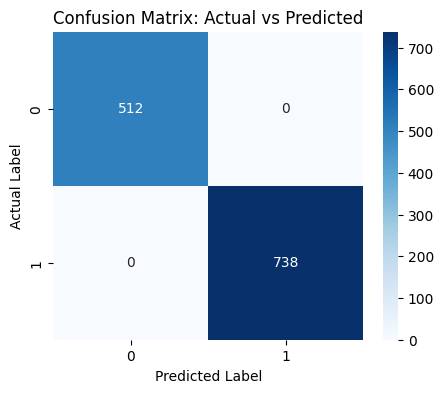

In [0]:
# ----------------------------------------
# 📦 Use Case 2: Predict Future Buying Behavior
# ----------------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ✅ Read dataset from Databricks FileStore (update path if different)
df = pd.read_excel("/Volumes/capston_project-priya_saini(24mbmb34)/default/capston_project-priya_saini(24mbmb34)/ecommerce_data.xlsx", parse_dates=["purchase_date"])

# ----------------------------------------
# Step 1: Customer-level Aggregation
# ----------------------------------------
cust = df.groupby("customer_id").agg(
    last_purchase_date=("purchase_date","max"),
    total_transactions=("transaction_id","count"),
    avg_order_value=("total_spent","mean"),
    avg_session_min=("session_duration_min","mean"),
    promo_rate=("promo_used","mean")
).reset_index()

# ----------------------------------------
# Step 2: Create target variable
# ----------------------------------------
dataset_end = df["purchase_date"].max()
cust["recency_days"] = (dataset_end - cust["last_purchase_date"]).dt.days
cust["will_purchase_next_30d"] = (cust["recency_days"] <= 30).astype(int)

# ----------------------------------------
# Step 3: Define features and label
# ----------------------------------------
X = cust[["total_transactions","avg_order_value","avg_session_min","promo_rate","recency_days"]].fillna(0)
y = cust["will_purchase_next_30d"]

# ----------------------------------------
# Step 4: Split & Train Model
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# ----------------------------------------
# Step 5: Evaluation
# ----------------------------------------
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
coef_df = pd.DataFrame({"feature": X.columns, "coef": clf.coef_.flatten()})

# ----------------------------------------
# Step 6: Visualizations (Databricks shows inline)
# ----------------------------------------

# 1️⃣ Recency Distribution
plt.figure(figsize=(8,5))
sns.histplot(cust["recency_days"], bins=15, color="skyblue", kde=True)
plt.title("Distribution of Customer Recency (Days Since Last Purchase)")
plt.xlabel("Recency Days")
plt.ylabel("Number of Customers")
plt.show()

# 2️⃣ Feature Correlation Heatmap
plt.figure(figsize=(7,6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# 3️⃣ Feature Importance
plt.figure(figsize=(7,5))
sns.barplot(x="coef", y="feature", data=coef_df, palette="viridis")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

# 4️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix: Actual vs Predicted")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


